aus:
https://github.com/randomaccess2023/MG2023/blob/main/Video%2048/DCGAN.ipynb

In [1]:
import torch
print('PyTorch version:', torch.__version__)
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
print('Torchvision version:', torchvision.__version__)
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121


In [2]:
#Define Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

Device is: cuda 

Total number of GPUs: 1


In [3]:
#Load fashion Mnist
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

fmnist_dataset = datasets.FashionMNIST(root='./data_src', train=True, download=True, transform=transform)
data_loader = DataLoader(fmnist_dataset, batch_size=256, shuffle=True, drop_last=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]


Extracting ./data_src/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_src/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting ./data_src/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_src/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]


Extracting ./data_src/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_src/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.6MB/s]

Extracting ./data_src/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_src/FashionMNIST/raw



In [4]:
#Discriminator
class DISCRIMINATOR(nn.Module):
    def __init__(self):
        super(DISCRIMINATOR, self).__init__()

        self.discriminator = nn.Sequential()
        self.discriminator.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1))
        self.discriminator.add_module('lrel1', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1))
        self.discriminator.add_module('bnor2', nn.BatchNorm2d(num_features=128))
        self.discriminator.add_module('lrel2', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('conv3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1))
        self.discriminator.add_module('bnor3', nn.BatchNorm2d(num_features=256))
        self.discriminator.add_module('lrel3', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('conv4', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1))
        self.discriminator.add_module('bnor4', nn.BatchNorm2d(num_features=512))
        self.discriminator.add_module('lrel4', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('conv5', nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4))
        self.discriminator.add_module('sgmd5', nn.Sigmoid())

    def forward(self, x):
        x = self.discriminator(x)
        return x

In [5]:
#Generator
class GENERATOR(nn.Module):
    def __init__(self):
        super(GENERATOR, self).__init__()

        self.generator = nn.Sequential()
        self.generator.add_module('tcon1', nn.ConvTranspose2d(in_channels=256, out_channels=1024, kernel_size=4))
        self.generator.add_module('relu1', nn.ReLU())
        self.generator.add_module('tcon2', nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('bnor2', nn.BatchNorm2d(num_features=512))
        self.generator.add_module('relu2', nn.ReLU())
        self.generator.add_module('tcon3', nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('bnor3', nn.BatchNorm2d(num_features=256))
        self.generator.add_module('relu3', nn.ReLU())
        self.generator.add_module('tcon4', nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('bnor4', nn.BatchNorm2d(num_features=128))
        self.generator.add_module('relu4', nn.ReLU())
        self.generator.add_module('tcon5', nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('tanh5', nn.Tanh())

    def forward(self, x):
        x = self.generator(x)
        return x

In [6]:
def random_noise(batch_size):
    noise = torch.randn(batch_size, 256, 1, 1)
    return noise

In [7]:
def discriminator_training_batch(real_samples, fake_samples, model, criterion, optimizer):

    model.train()

    preds_real = model(real_samples)
    error_real = criterion(preds_real.squeeze(), torch.ones(len(real_samples)).to(device))

    preds_fake = model(fake_samples)
    error_fake = criterion(preds_fake.squeeze(), torch.zeros(len(fake_samples)).to(device))

    optimizer.zero_grad()
    error_real.backward()
    error_fake.backward()
    optimizer.step()

    return error_real + error_fake

In [8]:
def generator_training_batch(fake_samples, model, criterion, optimizer):

    model.train()

    preds = model(fake_samples)
    error = criterion(preds.squeeze(), torch.ones(len(fake_samples)).to(device)) # to fool the discriminator

    optimizer.zero_grad()
    error.backward()
    optimizer.step()

    return error

In [9]:
discriminator = DISCRIMINATOR().to(device)
generator = GENERATOR().to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))

criterion = nn.BCELoss()

In [10]:
torch.manual_seed(111)
torch.cuda.manual_seed(111)
torch.cuda.manual_seed_all(111)
np.random.seed(111)

n_epochs = 10
discriminator_loss, generator_loss = [], []

for epoch in range(n_epochs):
    discriminator_losses, generator_losses = [], []

    for data, _ in tqdm(data_loader):

        real_data = data.to(device)
        fake_data = generator(random_noise(batch_size=256).to(device)).to(device)
        fake_data = fake_data.detach()

        discrim_batch_loss = discriminator_training_batch(real_samples=real_data, fake_samples=fake_data, model=discriminator,
                                                          criterion=criterion, optimizer=d_optimizer)
        discriminator_losses.append(discrim_batch_loss.item())

        fake_data = generator(random_noise(batch_size=256).to(device)).to(device)
        gen_batch_loss = generator_training_batch(fake_samples=fake_data, model=discriminator, criterion=criterion,
                                                  optimizer=g_optimizer)
        generator_losses.append(gen_batch_loss.item())

    discriminator_per_epoch_loss = np.array(discriminator_losses).mean()
    generator_per_epoch_loss = np.array(generator_losses).mean()

    discriminator_loss.append(discriminator_per_epoch_loss)
    generator_loss.append(generator_per_epoch_loss)

    if (epoch+1) % 5 == 0:
        print(f'Epoch: {epoch+1}/{n_epochs}\t| Discriminator loss: {discriminator_per_epoch_loss:.4f} |    ', end='')
        print(f'Generator loss: {generator_per_epoch_loss:.4f}')

100%|██████████| 234/234 [03:19<00:00,  1.17it/s]


Epoch: 5/10	| Discriminator loss: 1.0733 |    Generator loss: 1.8266


100%|██████████| 234/234 [03:19<00:00,  1.17it/s]

Epoch: 10/10	| Discriminator loss: 0.6637 |    Generator loss: 3.1440


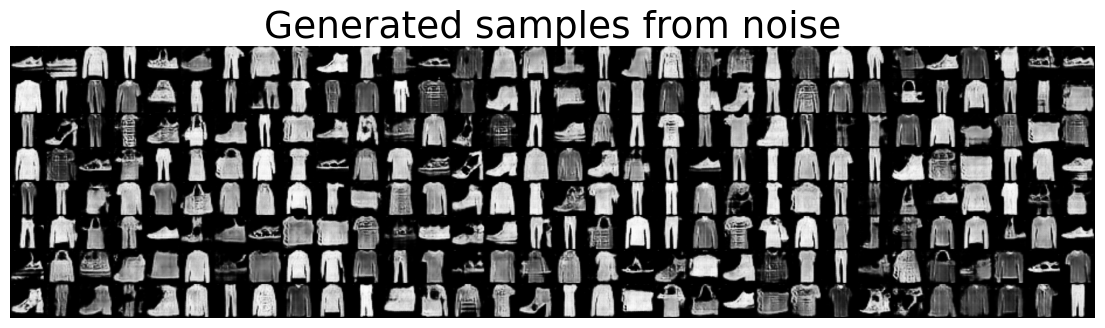

In [12]:
#Generate sample von noise
generator.eval()
n = torch.randn(256, 256, 1, 1)
random_samples = generator.cpu()(n)
grid = make_grid(random_samples, nrow=32, normalize=True)
plt.figure(figsize=(14, 6))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Generated samples from noise', fontsize=27);